In [1]:
!nvidia-smi

Fri Dec 20 14:33:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.5.1+cu121
True
12.1


In [2]:
!pip install cython pyyaml
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-c_c4a6e7
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-c_c4a6e7
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=376055 sha256=e36c3f97acf714a5f1b9ef59c469fdc73da366f4c286aed2f09889c3cf2d85f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-a4hd26am/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8
2.4.1+cu121 True
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the sour

In [3]:
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.4 MB/s eta 0:00:00


In [3]:
# install detectron2:
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.0/index.html

#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch/index.html
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.0/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [4]:
import os
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import hooks, launch
from detectron2.utils.logger import setup_logger
import logging
from detectron2.data import DatasetCatalog
setup_logger()
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [8]:
print("ibrainmomojj_lgmo")

ibrainmomojj_lgmo


In [5]:
import os
import json
from PIL import Image

def yolo_to_coco_json(yolo_dirs, image_dirs, output_dir, categories_offset=1):
    """
    تحويل تسميات YOLO إلى تنسيق COCO JSON مع ضبط فئات البيانات لتبدأ من 1.

    Args:
        yolo_dirs (dict): مجلدات التسميات (train, val, test).
        image_dirs (dict): مجلدات الصور (train, val, test).
        output_dir (str): المجلد الذي سيتم حفظ ملفات JSON فيه.
        categories_offset (int): إزاحة الفئات لتبدأ من 1 بدلًا من 0.
    """
    os.makedirs(output_dir, exist_ok=True)

    for split in ["train", "val", "test"]:
        yolo_dir = yolo_dirs[split]
        image_dir = image_dirs[split]
        output_json = os.path.join(output_dir, f"{split}_coco.json")

        coco_data = {
            "images": [],
            "annotations": [],
            "categories": [{"id": i + categories_offset, "name": f"class_{i + categories_offset}"}
                           for i in range(6)]  # تعديل الفئات لتبدأ من 1
        }

        annotation_id = 1
        image_id = 0

        for label_file in os.listdir(yolo_dir):
            if not label_file.endswith(".txt"):
                continue

            # معالجة الصورة
            image_name = label_file.replace(".txt", ".jpg")
            image_path = os.path.join(image_dir, image_name)

            if not os.path.exists(image_path):
                print(f"الصورة {image_name} غير موجودة. يتم تخطيها.")
                continue

            with Image.open(image_path) as img:
                image_width, image_height = img.size

            # إضافة معلومات الصورة
            coco_data["images"].append({
                "id": image_id,
                "file_name": image_name,
                "width": image_width,
                "height": image_height
            })

            # معالجة مربعات الإحاطة
            with open(os.path.join(yolo_dir, label_file), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0]) + categories_offset  # تعويض الإزاحة
                    center_x = float(parts[1]) * image_width
                    center_y = float(parts[2]) * image_height
                    width = float(parts[3]) * image_width
                    height = float(parts[4]) * image_height

                    # تحويل إلى x_min, y_min, width, height
                    x_min = int(center_x - (width / 2))
                    y_min = int(center_y - (height / 2))
                    x_max = int(center_x + (width / 2))
                    y_max = int(center_y + (height / 2))

                    coco_data["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": class_id,
                        "bbox": [x_min, y_min, width, height],
                        "area": width * height,
                        "iscrowd": 0
                    })
                    annotation_id += 1

            image_id += 1

        # حفظ ملف COCO JSON
        with open(output_json, "w") as json_file:
            json.dump(coco_data, json_file, indent=4)
        print(f"تم إنشاء ملف COCO JSON لـ {split}: {output_json}")

# استخدام الكود
yolo_dirs = {
    "train": "/kaggle/input/insect/new insect data/train/labels",
    "val": "/kaggle/input/insect/new insect data/valid/labels",
    "test": "/kaggle/input/insect/new insect data/test/labels"
}

image_dirs = {
    "train": "/kaggle/input/insect/new insect data/train/images",
    "val": "/kaggle/input/insect/new insect data/valid/images",
    "test": "/kaggle/input/insect/new insect data/test/images"
}

output_dir = "/kaggle/working/coco_dataset"

yolo_to_coco_json(yolo_dirs, image_dirs, output_dir)

تم إنشاء ملف COCO JSON لـ train: /kaggle/working/coco_dataset/train_coco.json
تم إنشاء ملف COCO JSON لـ val: /kaggle/working/coco_dataset/val_coco.json
تم إنشاء ملف COCO JSON لـ test: /kaggle/working/coco_dataset/test_coco.json


In [ ]:
print("ibao_momo_almahshi")

ibao_momo_almahshi


In [6]:
# تسجيل البيانات بتنسيق COCO
data_dir = "./"  # المجلد الرئيسي للبيانات
train_json = "/kaggle/working/coco_dataset/train_coco.json"  # ملف JSON لبيانات التدريب
val_json = "/kaggle/working/coco_dataset/val_coco.json"  # ملف JSON لبيانات التحقق
test_json = "/kaggle/working/coco_dataset/test_coco.json"

images_dir_train = "/kaggle/input/insect/new insect data/train/images"  # مجلد الصور
images_dir_valid = "/kaggle/input/insect/new insect data/valid/images"
images_dir_test = "/kaggle/input/insect/new insect data/test/images"
# تسجيل بيانات التدريب والتحقق
register_coco_instances("my_dataset_train", {}, train_json, images_dir_train)
register_coco_instances("my_dataset_val", {}, val_json, images_dir_valid )
register_coco_instances("my_dataset_test", {}, test_json,images_dir_test)

# طباعة معلومات عن البيانات
print("معلومات عن بيانات التدريب:")
print(f"عدد الصور في التدريب: {len(DatasetCatalog.get('my_dataset_train'))}")
print("معلومات عن بيانات التحقق:")
print(f"عدد الصور في التحقق: {len(DatasetCatalog.get('my_dataset_val'))}")

معلومات عن بيانات التدريب:
[12/20 14:44:11 d2.data.datasets.coco]: Loaded 12932 images in COCO format from /kaggle/working/coco_dataset/train_coco.json
عدد الصور في التدريب: 12932
معلومات عن بيانات التحقق:
[12/20 14:44:11 d2.data.datasets.coco]: Loaded 1735 images in COCO format from /kaggle/working/coco_dataset/val_coco.json
عدد الصور في التحقق: 1735


[12/20 14:44:26 d2.data.datasets.coco]: Loaded 12932 images in COCO format from /kaggle/working/coco_dataset/train_coco.json


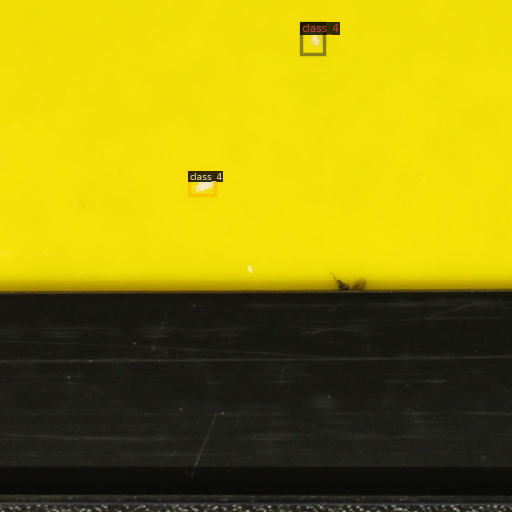

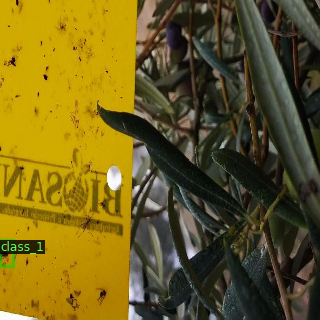

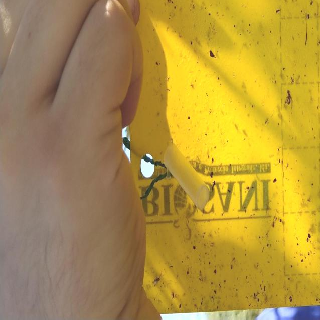

In [7]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
# # إعداد الكونفيغ
# cfg = get_cfg()
# cfg.merge_from_file("/content/faster_rcnn_R_101_FPN_3x.yaml")

# # تخصيص إعدادات التدريب والتحقق
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ("my_dataset_val",)
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
# cfg.SOLVER.IMS_PER_BATCH = 2  # عدد الصور لكل تكرار
# cfg.SOLVER.BASE_LR = 0.001  # معدل التعلم
# cfg.SOLVER.MAX_ITER = 2000  # عدد التكرارات الكلية
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # عدد الفئات في البيانات (من 1 إلى 6)
# cfg.TEST.EVAL_PERIOD = 200  # تقييم الأداء كل 200 تكرار
# cfg.OUTPUT_DIR = "./output"
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# # تهيئة السجلات
# setup_logger()
# logger = logging.getLogger("detectron2")
# logger.info("بدء التدريب...")

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [27]:

#torch.cuda.empty_cache()


In [9]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 500  
cfg.SOLVER.MAX_ITER = 5000  
cfg.SOLVER.STEPS = (3500, 4500)  

cfg.SOLVER.GAMMA = 0.05  





cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
#print("تم الانتهاء من التدريب. النموذج النهائي محفوظ في المجلد:", cfg.OUTPUT_DIR)

[12/20 14:44:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:02, 173MB/s]                               


[12/20 14:44:53 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/20 14:45:51 d2.utils.events]:  eta: 3:59:15  iter: 19  total_loss: 2.8  loss_cls: 1.94  loss_box_reg: 0.3119  loss_rpn_cls: 0.587  loss_rpn_loc: 0.04042    time: 2.7951  last_time: 2.9441  data_time: 0.0210  last_data_time: 0.0103   lr: 3.8962e-05  max_mem: 6868M
[12/20 14:46:55 d2.utils.events]:  eta: 3:58:04  iter: 39  total_loss: 1.679  loss_cls: 0.9367  loss_box_reg: 0.4338  loss_rpn_cls: 0.1908  loss_rpn_loc: 0.06949    time: 2.8241  last_time: 2.8210  data_time: 0.0116  last_data_time: 0.0122   lr: 7.8922e-05  max_mem: 6869M
[12/20 14:47:52 d2.utils.events]:  eta: 3:56:47  iter: 59  total_loss: 1.243  loss_cls: 0.5871  loss_box_reg: 0.5448  loss_rpn_cls: 0.07423  loss_rpn_loc: 0.06008    time: 2.8268  last_time: 3.0763  data_time: 0.0112  last_data_time: 0.0094   lr: 0.00011888  max_mem: 6869M
[12/20 14:48:50 d2.utils.events]:  eta: 3:55:50  iter: 79  total_loss: 1.468  loss_cls: 0.6484  loss_box_reg: 0.6413  loss_rpn_cls: 0.09515  loss_rpn_loc: 0.04474    time: 2.8509  last_

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 15:09:18 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1902 s/iter. Eval: 0.0003 s/iter. Total: 0.1918 s/iter. ETA=0:05:30
[12/20 15:09:23 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0017 s/iter. Inference: 0.1908 s/iter. Eval: 0.0003 s/iter. Total: 0.1929 s/iter. ETA=0:05:27
[12/20 15:09:28 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0017 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:22
[12/20 15:09:33 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:17
[12/20 15:09:38 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:12
[12/20 15:09:43 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0017 s/iter. Inference: 0.1912 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 15:39:15 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1918 s/iter. Eval: 0.0003 s/iter. Total: 0.1933 s/iter. ETA=0:05:33
[12/20 15:39:20 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0016 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1930 s/iter. ETA=0:05:27
[12/20 15:39:25 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:22
[12/20 15:39:31 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:17
[12/20 15:39:36 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1932 s/iter. ETA=0:05:12
[12/20 15:39:41 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 16:09:09 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1902 s/iter. Eval: 0.0003 s/iter. Total: 0.1917 s/iter. ETA=0:05:30
[12/20 16:09:14 d2.evaluation.evaluator]: Inference done 38/1735. Dataloading: 0.0017 s/iter. Inference: 0.1900 s/iter. Eval: 0.0003 s/iter. Total: 0.1921 s/iter. ETA=0:05:25
[12/20 16:09:19 d2.evaluation.evaluator]: Inference done 64/1735. Dataloading: 0.0017 s/iter. Inference: 0.1902 s/iter. Eval: 0.0003 s/iter. Total: 0.1923 s/iter. ETA=0:05:21
[12/20 16:09:25 d2.evaluation.evaluator]: Inference done 91/1735. Dataloading: 0.0017 s/iter. Inference: 0.1902 s/iter. Eval: 0.0003 s/iter. Total: 0.1923 s/iter. ETA=0:05:16
[12/20 16:09:30 d2.evaluation.evaluator]: Inference done 118/1735. Dataloading: 0.0017 s/iter. Inference: 0.1902 s/iter. Eval: 0.0003 s/iter. Total: 0.1923 s/iter. ETA=0:05:10
[12/20 16:09:35 d2.evaluation.evaluator]: Inference done 145/1735. Dataloading: 0.0017 s/iter. Inference: 0.1902 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 16:38:56 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1905 s/iter. Eval: 0.0002 s/iter. Total: 0.1920 s/iter. ETA=0:05:30
[12/20 16:39:01 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0017 s/iter. Inference: 0.1904 s/iter. Eval: 0.0002 s/iter. Total: 0.1925 s/iter. ETA=0:05:26
[12/20 16:39:06 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0017 s/iter. Inference: 0.1905 s/iter. Eval: 0.0003 s/iter. Total: 0.1926 s/iter. ETA=0:05:21
[12/20 16:39:11 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0017 s/iter. Inference: 0.1905 s/iter. Eval: 0.0003 s/iter. Total: 0.1926 s/iter. ETA=0:05:16
[12/20 16:39:16 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0017 s/iter. Inference: 0.1906 s/iter. Eval: 0.0003 s/iter. Total: 0.1926 s/iter. ETA=0:05:12
[12/20 16:39:21 d2.evaluation.evaluator]: Inference done 142/1735. Dataloading: 0.0017 s/iter. Inference: 0.1905 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 17:08:40 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1906 s/iter. Eval: 0.0003 s/iter. Total: 0.1922 s/iter. ETA=0:05:31
[12/20 17:08:45 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0017 s/iter. Inference: 0.1908 s/iter. Eval: 0.0003 s/iter. Total: 0.1930 s/iter. ETA=0:05:27
[12/20 17:08:50 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0017 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:22
[12/20 17:08:55 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0017 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:17
[12/20 17:09:00 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0018 s/iter. Inference: 0.1909 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:12
[12/20 17:09:05 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0018 s/iter. Inference: 0.1909 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 17:38:22 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0014 s/iter. Inference: 0.1904 s/iter. Eval: 0.0002 s/iter. Total: 0.1921 s/iter. ETA=0:05:31
[12/20 17:38:27 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0017 s/iter. Inference: 0.1904 s/iter. Eval: 0.0002 s/iter. Total: 0.1925 s/iter. ETA=0:05:26
[12/20 17:38:32 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0017 s/iter. Inference: 0.1905 s/iter. Eval: 0.0002 s/iter. Total: 0.1925 s/iter. ETA=0:05:21
[12/20 17:38:37 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0017 s/iter. Inference: 0.1906 s/iter. Eval: 0.0002 s/iter. Total: 0.1927 s/iter. ETA=0:05:17
[12/20 17:38:42 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0017 s/iter. Inference: 0.1907 s/iter. Eval: 0.0003 s/iter. Total: 0.1928 s/iter. ETA=0:05:12
[12/20 17:38:47 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0018 s/iter. Inference: 0.1906 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 18:08:20 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1926 s/iter. ETA=0:05:32
[12/20 18:08:25 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0016 s/iter. Inference: 0.1906 s/iter. Eval: 0.0003 s/iter. Total: 0.1927 s/iter. ETA=0:05:27
[12/20 18:08:30 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0017 s/iter. Inference: 0.1909 s/iter. Eval: 0.0003 s/iter. Total: 0.1930 s/iter. ETA=0:05:22
[12/20 18:08:35 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0017 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:17
[12/20 18:08:40 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0017 s/iter. Inference: 0.1910 s/iter. Eval: 0.0003 s/iter. Total: 0.1932 s/iter. ETA=0:05:12
[12/20 18:08:45 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0017 s/iter. Inference: 0.1911 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 18:38:15 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0013 s/iter. Inference: 0.1912 s/iter. Eval: 0.0002 s/iter. Total: 0.1928 s/iter. ETA=0:05:32
[12/20 18:38:20 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0019 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1934 s/iter. ETA=0:05:28
[12/20 18:38:25 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0019 s/iter. Inference: 0.1912 s/iter. Eval: 0.0003 s/iter. Total: 0.1935 s/iter. ETA=0:05:23
[12/20 18:38:30 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0019 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1934 s/iter. ETA=0:05:18
[12/20 18:38:35 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0019 s/iter. Inference: 0.1911 s/iter. Eval: 0.0003 s/iter. Total: 0.1934 s/iter. ETA=0:05:13
[12/20 18:38:40 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0019 s/iter. Inference: 0.1911 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 19:08:11 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0012 s/iter. Inference: 0.1922 s/iter. Eval: 0.0003 s/iter. Total: 0.1936 s/iter. ETA=0:05:33
[12/20 19:08:16 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0017 s/iter. Inference: 0.1905 s/iter. Eval: 0.0003 s/iter. Total: 0.1926 s/iter. ETA=0:05:27
[12/20 19:08:21 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0018 s/iter. Inference: 0.1906 s/iter. Eval: 0.0003 s/iter. Total: 0.1927 s/iter. ETA=0:05:22
[12/20 19:08:26 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0018 s/iter. Inference: 0.1906 s/iter. Eval: 0.0003 s/iter. Total: 0.1927 s/iter. ETA=0:05:17
[12/20 19:08:31 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0018 s/iter. Inference: 0.1906 s/iter. Eval: 0.0003 s/iter. Total: 0.1927 s/iter. ETA=0:05:12
[12/20 19:08:36 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0018 s/iter. Inference: 0.1906 s/iter. Eva

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/20 19:38:08 d2.evaluation.evaluator]: Inference done 11/1735. Dataloading: 0.0015 s/iter. Inference: 0.1904 s/iter. Eval: 0.0003 s/iter. Total: 0.1922 s/iter. ETA=0:05:31
[12/20 19:38:13 d2.evaluation.evaluator]: Inference done 37/1735. Dataloading: 0.0018 s/iter. Inference: 0.1909 s/iter. Eval: 0.0003 s/iter. Total: 0.1931 s/iter. ETA=0:05:27
[12/20 19:38:19 d2.evaluation.evaluator]: Inference done 63/1735. Dataloading: 0.0019 s/iter. Inference: 0.1912 s/iter. Eval: 0.0003 s/iter. Total: 0.1935 s/iter. ETA=0:05:23
[12/20 19:38:24 d2.evaluation.evaluator]: Inference done 89/1735. Dataloading: 0.0019 s/iter. Inference: 0.1913 s/iter. Eval: 0.0003 s/iter. Total: 0.1935 s/iter. ETA=0:05:18
[12/20 19:38:29 d2.evaluation.evaluator]: Inference done 115/1735. Dataloading: 0.0019 s/iter. Inference: 0.1914 s/iter. Eval: 0.0003 s/iter. Total: 0.1937 s/iter. ETA=0:05:13
[12/20 19:38:34 d2.evaluation.evaluator]: Inference done 141/1735. Dataloading: 0.0019 s/iter. Inference: 0.1915 s/iter. Eva

In [11]:
####5 h

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 701), started 0:00:14 ago. (Use '!kill 701' to kill it.)

<IPython.core.display.Javascript object>